# <center> E-commerce Customer Data For Behavior Analysis </center>

## [1. Imports](#im) ##
## [2. HyperParameters](#hp) ##
## [3. Data Loading and Preprocessing](#data) ##
## [4. NN-LSTM Model](#lstm) ##
## [5. Comparison with other Models](#com) ##
###    [5.1 Logistic Regression](#lr) ###
###    [5.2 Naive Bayes](#nb) ###
###    [5.3 Support Vector Classifier(SVC)](#sv) ###
###    [5.4 Random Forest Classifier](#rf) ###
###    [5.5 XGB Classifier](#xg) ###
## [6. Performance Metrics Comparision](#per) ##


<a id="im"></a>
# <center>IMPORTING LIBRARIES</center> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [2]:
input_dir = "C:/Users/ashwi/Desktop/ML_Project/Input/olist_order_reviews_dataset.csv"
 

# HYPERPARAMETERS
RANDOM_STATE = 12
TRAIN_SPLIT = 0.80
OOV_TOK = "<OOV>"
VOCAB_SIZE = 10000
EMBEDDING_DIM = 16
MAX_LENGTH = 120
BATCH_SIZE=128
EPOCHS=25
EARLY_STOPPING_CRITERIA=3
DROPOUT_P=0.4
LEARNING_RATE = 0.01
MOMENTUM =0.9
MAX_ITER = 10000
N_JOBS = 4



<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [3]:
data = pd.read_csv(input_dir)
data.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

In [4]:
def clean_data(data, column_text='review_comment_message', 
               column_score='review_score', 
               points_cut = [0, 2, 5], 
               classes = [0, 1]):
    
    df_bin = data
    df_bin = df_bin.dropna(subset=[column_text])
    df_bin['label'] = pd.cut(df_bin[column_score], bins=points_cut, labels=classes)
    df_bin = df_bin.rename(columns={column_text: 'text'})
    df_bin = df_bin[['text','label']]
    
    df_cat = data
    df_cat = df_cat.dropna(subset=[column_text])
    df_cat = df_cat.rename(columns={column_text: 'text' , column_score: 'label'})
    df_cat = df_cat[['text','label']]
    return df_bin ,df_cat


data_bin , data_cat = clean_data(data)

# EDA


In [5]:
pip install folium --upgrade

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# Utilities
from viz_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
"""import lightgbm as lgb"""

'import lightgbm as lgb'

In [7]:
# Reading all the files
raw_path = 'C:/Users/ashwi/Desktop/ML_Project/Input/'
olist_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')

In [8]:
# Collections for each dataset
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

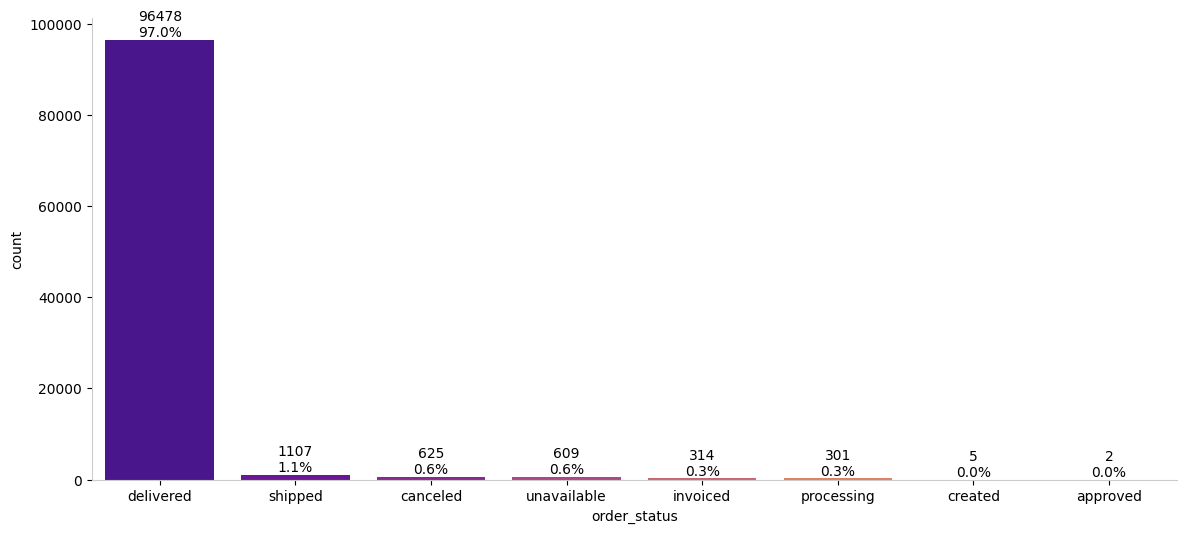

In [9]:
df_orders = olist_orders.merge(olist_customer, how='left', on='customer_id')
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(df_orders, x='order_status', ax=ax)
plt.show()

In [10]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix            customer_city customer_state  \
0                      3149                sao paulo             SP   
1                     47813                barreiras             BA   
2                     75265               vianopolis             GO   
3                     59296  sao goncalo do amarante             RN   
4                      9195              santo andre             SP   

   order_purchase_year  order_purchase_month order_purchase_month_name  \
0                 2017                    10                       Oct   
1                 2018                     7                       Jul   
2                 2018                     8                       Aug   
3                 2017                    11                       Nov   
4                 2018                     2                       Feb   

  order_purchase_year_month order_purchase_date  order_purchase_day  \
0                    201710            20171002                   2   
1                    201807            20180724                  24   
2                    201808            20180808                   8   
3                    201711            20171118                  18   
4                    201802            20180213                  13   

   order_purchase_dayofweek order_purchase_dayofweek_name  \
0                         0                           Mon   
1                         1                           Tue   
2                         2                           Wed   
3                         5                           Sat   
4                         1                           Tue   

   order_purchase_hour order_purchase_time_day  
0                   10                 Morning  
1                   20                   Night  
2                    8                 Morning  
3                   19                   Night  
4                   21                   Night

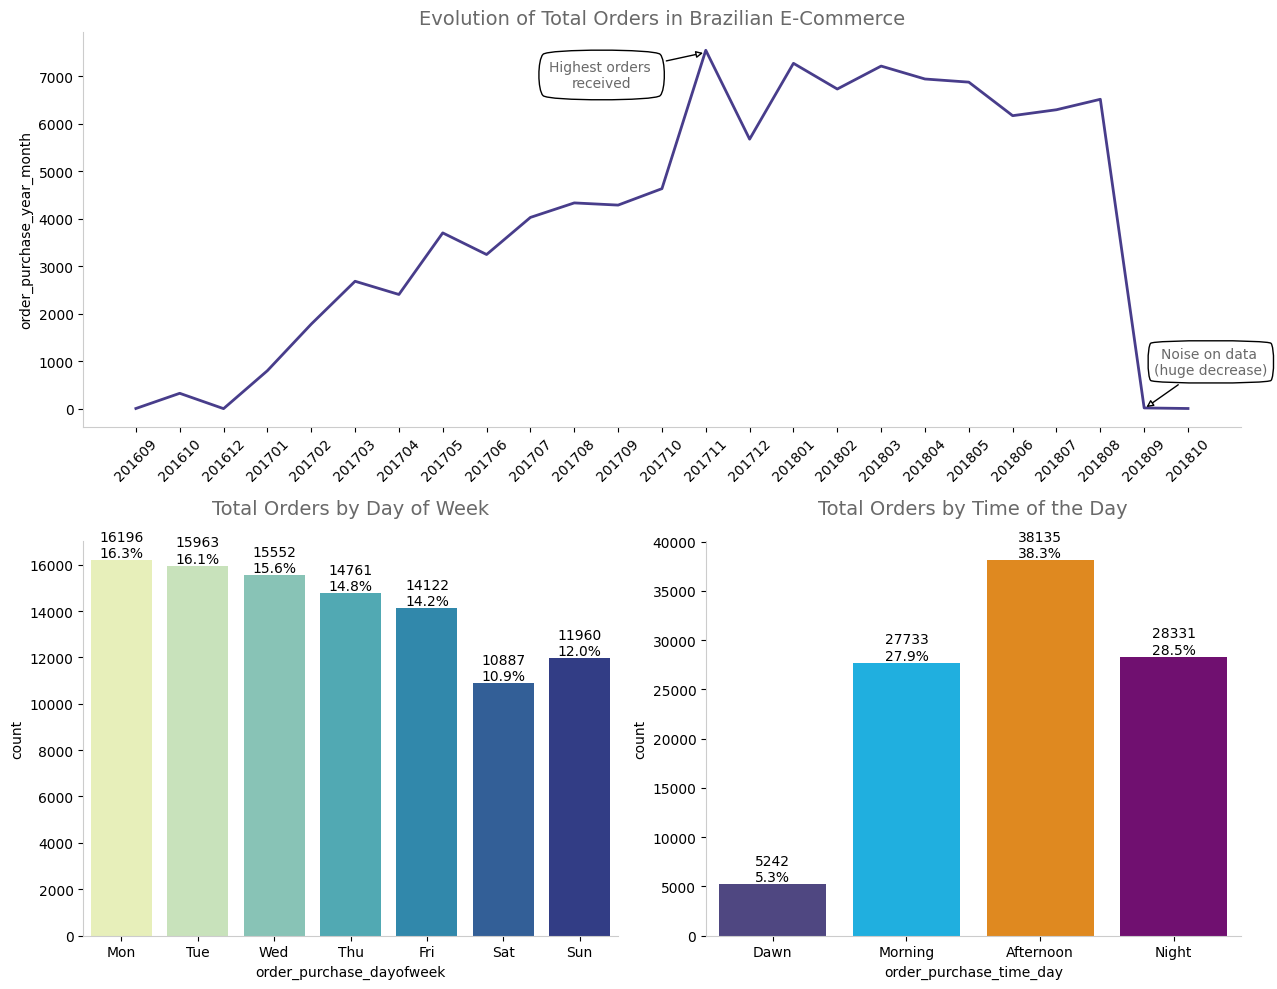

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')

# Barchart - Total of orders by day of week
single_countplot(df_orders, x='order_purchase_dayofweek', ax=ax2, order=False, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(df_orders, x='order_purchase_time_day', ax=ax3, order=False, palette=day_color_list)
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

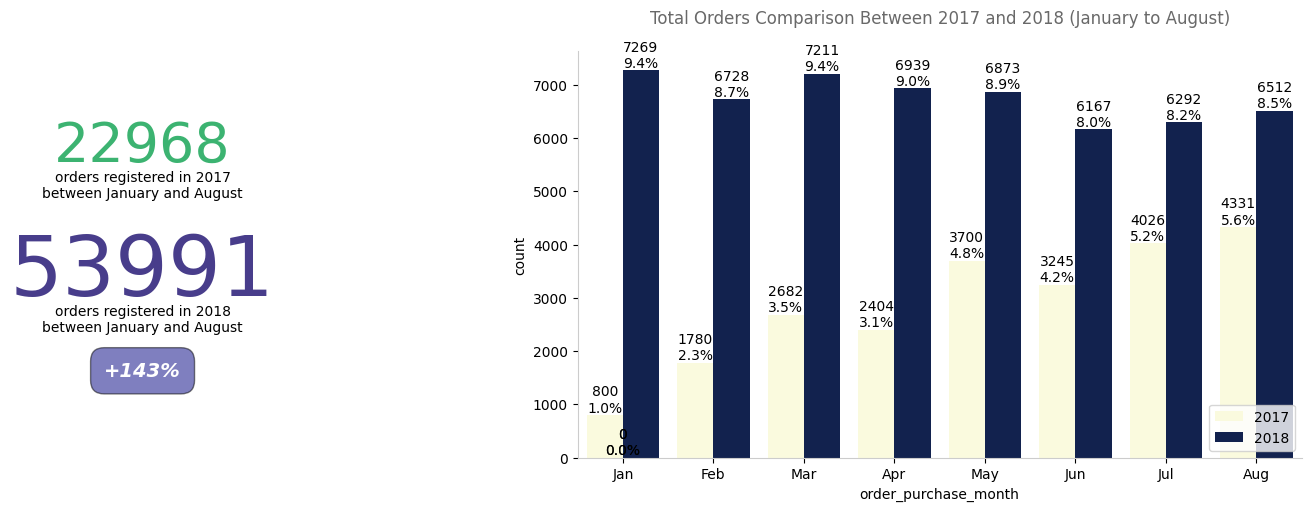

In [12]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Annotation - Grown on e-commerce orders between 2017 and 2018
df_orders_compare = df_orders.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
year_orders = df_orders_compare['order_purchase_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax1.text(0.00, 0.73, f'{year_orders[2017]}', fontsize=40, color='mediumseagreen', ha='center')
ax1.text(0.00, 0.64, 'orders registered in 2017\nbetween January and August', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'{year_orders[2018]}', fontsize=60, color='darkslateblue', ha='center')
ax1.text(0.00, 0.31, 'orders registered in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# Bar chart - Comparison between monthly sales between 2017 and 2018
single_countplot(df_orders_compare, x='order_purchase_month', hue='order_purchase_year', ax=ax2, order=False,
                 palette='YlGnBu')
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
ax2.set_xticklabels(month_label)
ax2.set_title('Total Orders Comparison Between 2017 and 2018 (January to August)', size=12, color='dimgrey', pad=20)
plt.legend(loc='lower right')
plt.show()

In [13]:
# Merging orders and order_items
df_orders_items = df_orders.merge(olist_order_items, how='left', on='order_id')

# Using the API to bring the region to the data
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# Threting geolocations outside brazilian map

#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo_prep = olist_geolocation[olist_geolocation.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Merging all the informations
df_orders_items = df_orders_items.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_orders_items = df_orders_items.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')
df_orders_items.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix            customer_city customer_state  \
0                      3149                sao paulo             SP   
1                     47813                barreiras             BA   
2                     75265               vianopolis             GO   
3                     59296  sao goncalo do amarante             RN   
4                      9195              santo andre             SP   

   order_purchase_year  order_purchase_month order_purchase_month_name  \
0                 2017                    10                       Oct   
1                 2018                     7                       Jul   
2                 2018                     8                       Aug   
3                 2017                    11                       Nov   
4                 2018                     2                       Feb   

  order_purchase_year_month order_purchase_date  order_purchase_day  \
0                    201710            20171002                   2   
1                    201807            20180724                  24   
2                    201808            20180808                   8   
3                    201711            20171118                  18   
4                    201802            20180213                  13   

   order_purchase_dayofweek order_purchase_dayofweek_name  \
0                         0                           Mon   
1                         1                           Tue   
2                         2                           Wed   
3                         5                           Sat   
4                         1                           Tue   

   order_purchase_hour order_purchase_time_day  order_item_id  \
0                   10                 Morning            1.0   
1                   20                   Night            1.0   
2                    8                 Morning            1.0   
3                   19                   Night            1.0   
4                   21                   Night            1.0   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
3  d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b

In [14]:
# Filtering data between 201701 and 201808
df_orders_filt = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filt = df_orders_filt[(df_orders_filt['order_purchase_year_month'].astype(int) <= 201808)]

# Grouping data by region
df_regions_group = df_orders_filt.groupby(by=['order_purchase_year_month', 'nome_regiao'], as_index=False)
df_regions_group = df_regions_group.agg({'customer_id': 'count', 'price': 'sum'}).sort_values(by='order_purchase_year_month')
df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
df_regions_group.reset_index(drop=True, inplace=True)

# Grouping data by city (top 10)
df_cities_group = df_orders_filt.groupby(by='geolocation_city', 
                                       as_index=False).count().loc[:, ['geolocation_city', 'order_id']]
df_cities_group = df_cities_group.sort_values(by='order_id', ascending=False).reset_index(drop=True)
df_cities_group = df_cities_group.iloc[:10, :]

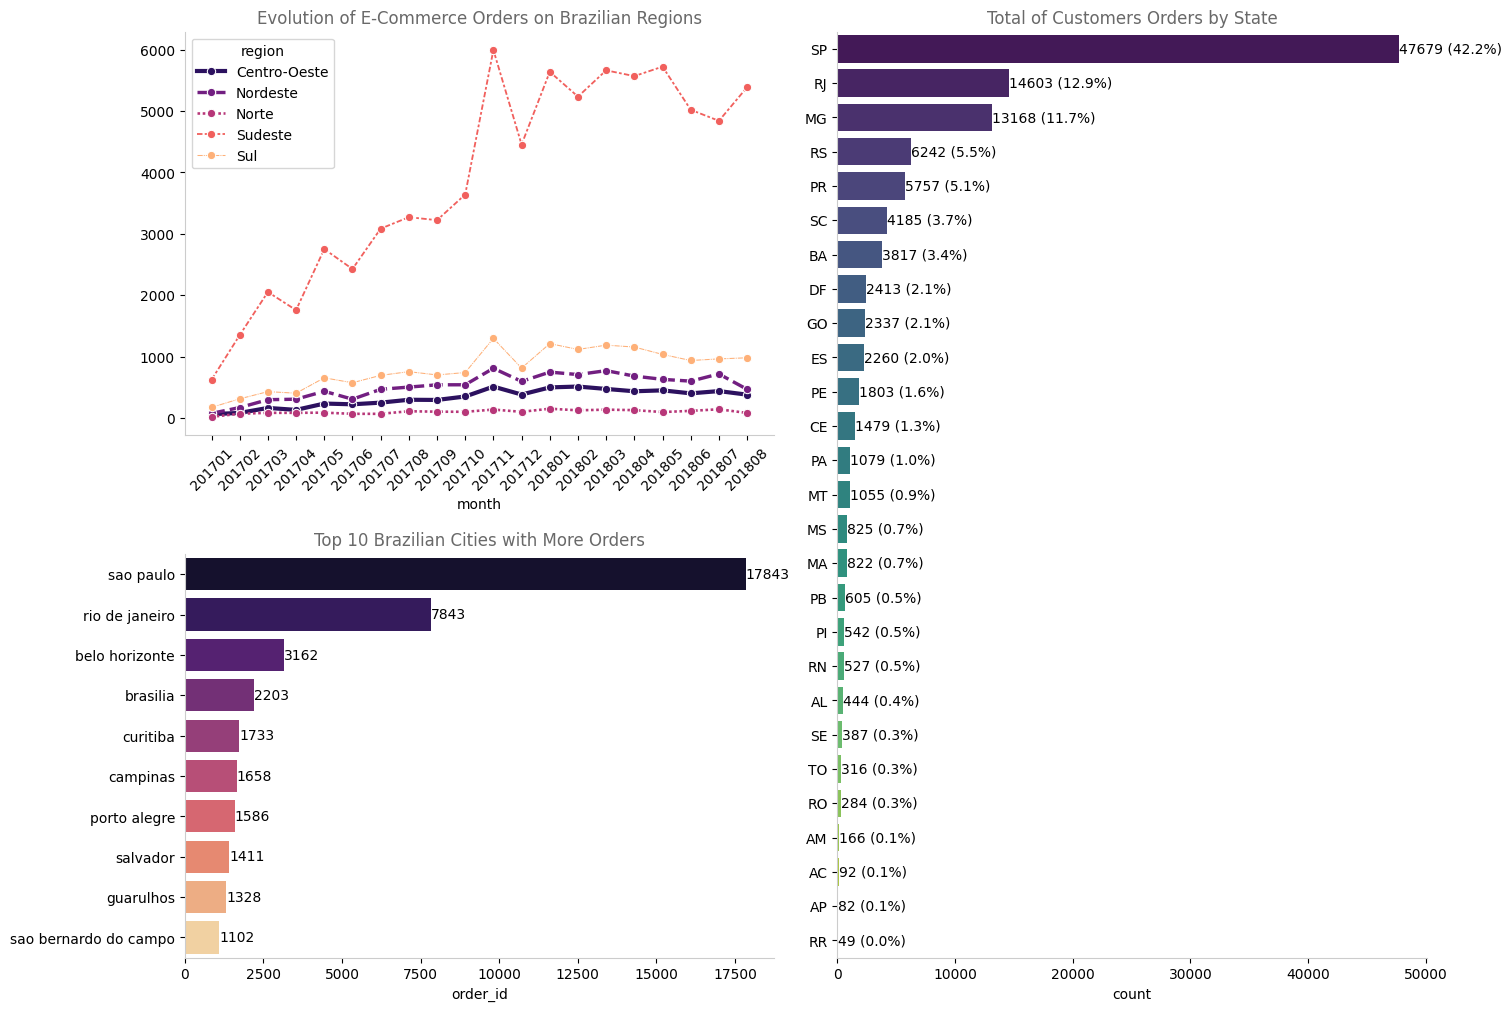

In [15]:
# Creating and preparing figure and axis
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

# Count of orders by region
sns.lineplot(x='month', y='order_count', ax=ax1, data=df_regions_group, hue='region', 
             size='region', style='region', palette='magma', markers=['o'] * 5)
format_spines(ax1, right_border=False)
ax1.set_title('Evolution of E-Commerce Orders on Brazilian Regions', size=12, color='dimgrey')
ax1.set_ylabel('')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Top cities with more customers orders in Brazil
sns.barplot(y='geolocation_city', x='order_id', data=df_cities_group, ax=ax2, palette='magma')
AnnotateBars(n_dec=0, font_size=10, color='black').horizontal(ax2)
format_spines(ax2, right_border=False)
ax2.set_title('Top 10 Brazilian Cities with More Orders', size=12, color='dimgrey')
ax2.set_ylabel('')

# Total orders by state
single_countplot(y='customer_state', ax=ax3, df=df_orders_filt, palette='viridis')
ax3.set_title('Total of Customers Orders by State', size=12, color='dimgrey')
ax3.set_ylabel('')

plt.show()

In [16]:
# Zipping locations
lats = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)[:30000]
longs = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)[:30000]
locations = list(zip(lats, longs))

# Creating a mapa using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

In [17]:
# Grouping geolocation data for plotting a heatmap
heat_data = df_orders_filt.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]

# Creating a mapa using folium
map1 = folium.Map(
    location=[-15, -50], 
    zoom_start=4.0, 
    tiles='cartodbdark_matter'
)

# Plugin: HeatMap
HeatMap(
    name='Mapa de Calor',
    data=heat_data,
    radius=10,
    max_zoom=13
).add_to(map1)

map1

In [18]:
epoch_list = []
heatmap_evl_data = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201801)]
heatmap_evl_data = heatmap_evl_data[(heatmap_evl_data['order_purchase_year_month'].astype(int) <= 201807)]
time_index = heatmap_evl_data['order_purchase_year_month'].sort_values().unique()
for epoch in time_index:
    data_temp = heatmap_evl_data.query('order_purchase_year_month == @epoch')
    data_temp = data_temp.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count()
    data_temp = data_temp.sort_values(by='order_id', ascending=False).iloc[:, :3]
    epoch_list.append(data_temp.values.tolist())
    
# Creating a mapa using folium
map2 = folium.Map(
    location=[-15, -50], 
    zoom_start=4.0, 
    tiles='cartodbdark_matter'
)

# Plugin: HeatMapWithTime
HeatMapWithTime(
    name='Evolution of Orders in a Geolocation Perspective',
    data=epoch_list,
    radius=10,
    index=list(time_index)
).add_to(map2)

map2

In [19]:
# Grouping data
df_month_aggreg = df_orders_filt.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False)
df_month_aggreg = df_month_aggreg.agg({
    'order_id': 'count',
    'price': 'sum',
    'freight_value': 'sum'
})

# Adding new columns for analysis
df_month_aggreg['price_per_order'] = df_month_aggreg['price'] / df_month_aggreg['order_id']
df_month_aggreg['freight_per_order'] = df_month_aggreg['freight_value'] / df_month_aggreg['order_id']
df_month_aggreg.head()

order_purchase_year order_purchase_year_month  order_id      price  \
0                 2017                    201701       966  120312.87   
1                 2017                    201702      1998  247303.02   
2                 2017                    201703      3041  374344.30   
3                 2017                    201704      2697  359927.23   
4                 2017                    201705      4176  506071.14   

   freight_value  price_per_order  freight_per_order  
0       16875.62       124.547484          17.469586  
1       38977.60       123.775285          19.508308  
2       57704.29       123.099079          18.975432  
3       52495.01       133.454664          19.464223  
4       80119.81       121.185618          19.185778

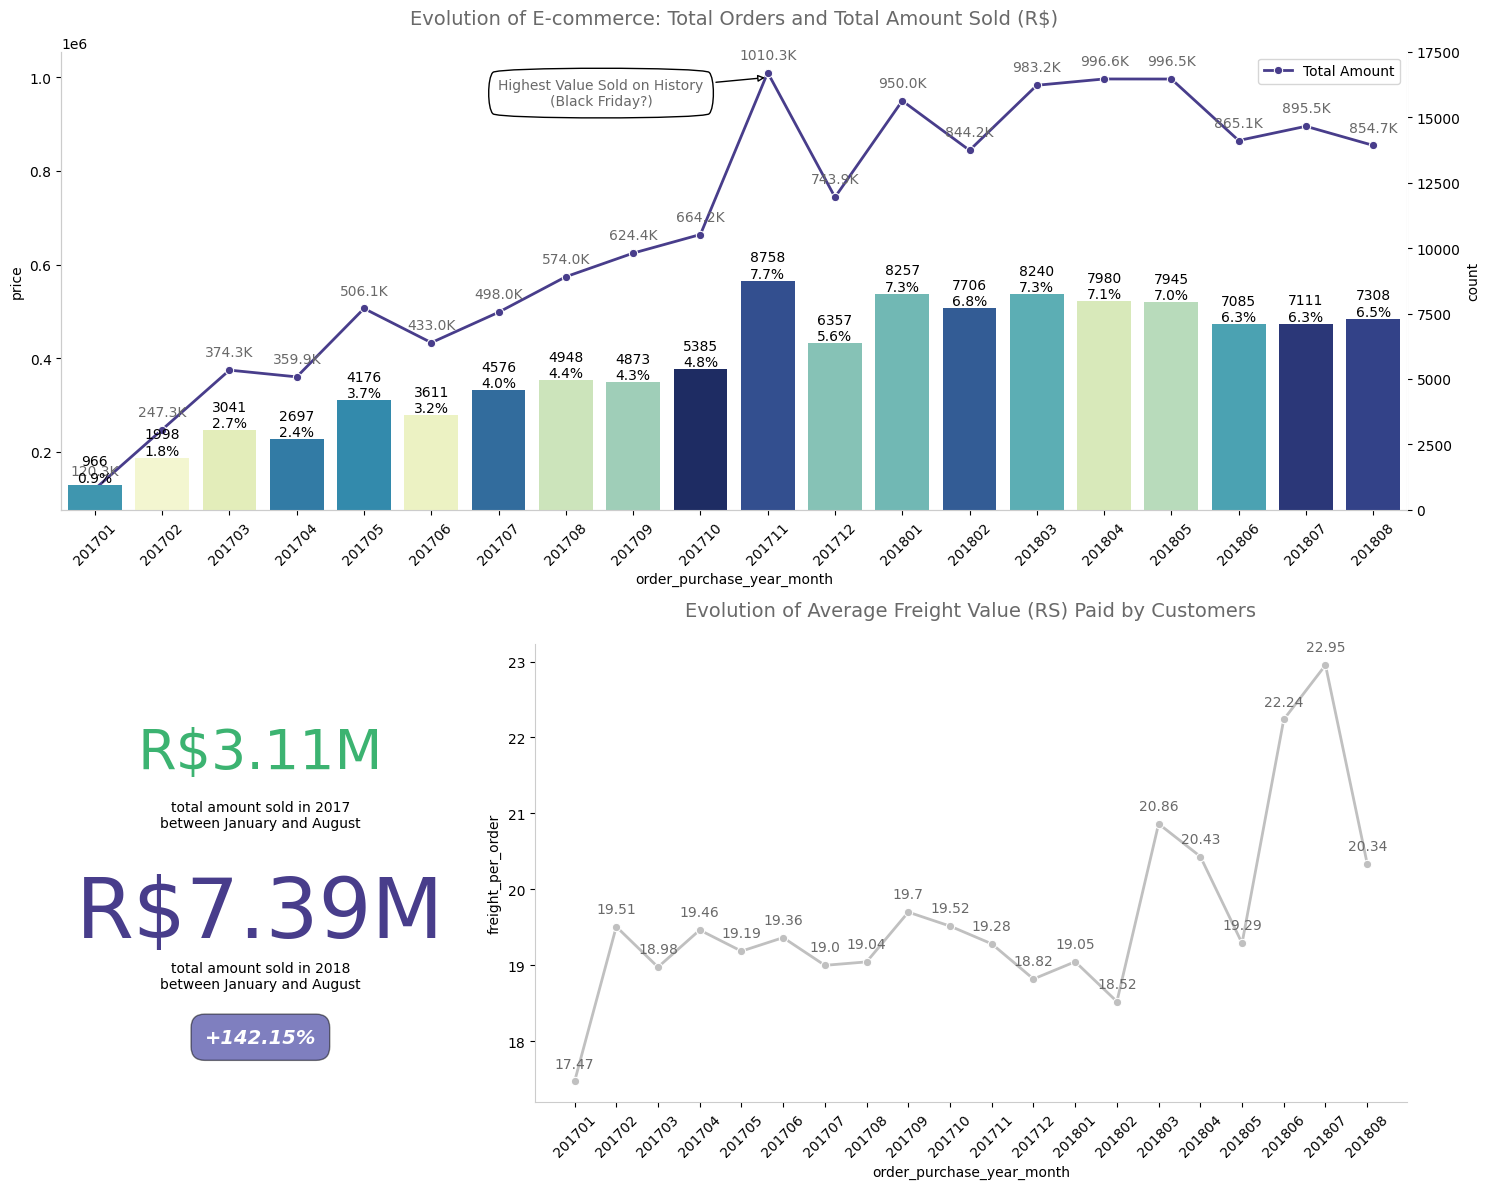

In [20]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1:])

# Plot 1 - Evolution of total orders and total sales on e-commerce
sns.lineplot(x='order_purchase_year_month', y='price', ax=ax1, data=df_month_aggreg, linewidth=2, 
             color='darkslateblue', marker='o', label='Total Amount')
ax1_twx = ax1.twinx()
single_countplot(df_orders_filt, x='order_purchase_year_month', ax=ax1_twx, order=False, palette='YlGnBu_r')
ax1_twx.set_yticks(np.arange(0, 20000, 2500))

# Customizing the first plot
format_spines(ax1)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.price.items():
    ax1.annotate(str(round(y/1000, 1))+'K', xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='dimgrey')
ax1.annotate(f'Highest Value Sold on History\n(Black Friday?)', (10, 1000000), xytext=(-120, -20), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.set_title('Evolution of E-commerce: Total Orders and Total Amount Sold (R$)', size=14, color='dimgrey', pad=20)

# Plot 2 - Big Numbers of Sales Evolution
month_comparison = ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708',
                    '201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808']
df_sales_compare = df_month_aggreg.query('order_purchase_year_month in (@month_comparison)')
sold_2017 = df_sales_compare.query('order_purchase_year == 2017')['price'].sum()
sold_2018 = df_sales_compare.query('order_purchase_year == 2018')['price'].sum()
growth = 1 + (sold_2017 / sold_2018)
ax2.text(0.50, 0.73, 'R$' + str(round(sold_2017/1000000, 2)) + 'M', fontsize=40, color='mediumseagreen', ha='center')
ax2.text(0.50, 0.60, 'total amount sold in 2017\nbetween January and August', fontsize=10, ha='center')
ax2.text(0.50, 0.36, 'R$' + str(round(sold_2018/1000000, 2)) + 'M', fontsize=60, color='darkslateblue', ha='center')
ax2.text(0.50, 0.25, 'total amount sold in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax2.text(0.50, 0.13, f'{signal}{str(round(100 * growth, 2))}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.axis('off')

# Plot 3 - Evolution of mean freight value paid by the customers
sns.lineplot(x='order_purchase_year_month', y='freight_per_order', data=df_month_aggreg, linewidth=2, 
             color='silver', marker='o', ax=ax3)
format_spines(ax3, right_border=False)
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.freight_per_order.items():
    ax3.annotate(round(y, 2), xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='dimgrey')
ax3.set_title('Evolution of Average Freight Value (RS) Paid by Customers', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

def mean_sum_analysis(df, groupby_col, agg_col, palette='viridis', figsize=(10, 6)):
    # Convert 'price' column to numeric
    df[agg_col] = pd.to_numeric(df[agg_col], errors='coerce')
    
    # Group by the specified column and calculate mean and sum
    grouped_df = df.groupby(groupby_col)[agg_col].agg(['mean', 'sum']).reset_index()
    
    # Plotting
    plt.figure(figsize=figsize)
    sns.barplot(x=groupby_col, y='mean', data=grouped_df, color='skyblue', label='Mean', palette=palette)
    sns.barplot(x=groupby_col, y='sum', data=grouped_df, color='orange', label='Sum', palette=palette)
    plt.xlabel(groupby_col.capitalize())
    plt.ylabel('Value')
    plt.title(f'Mean and Sum Analysis of {agg_col.capitalize()} by {groupby_col.capitalize()}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


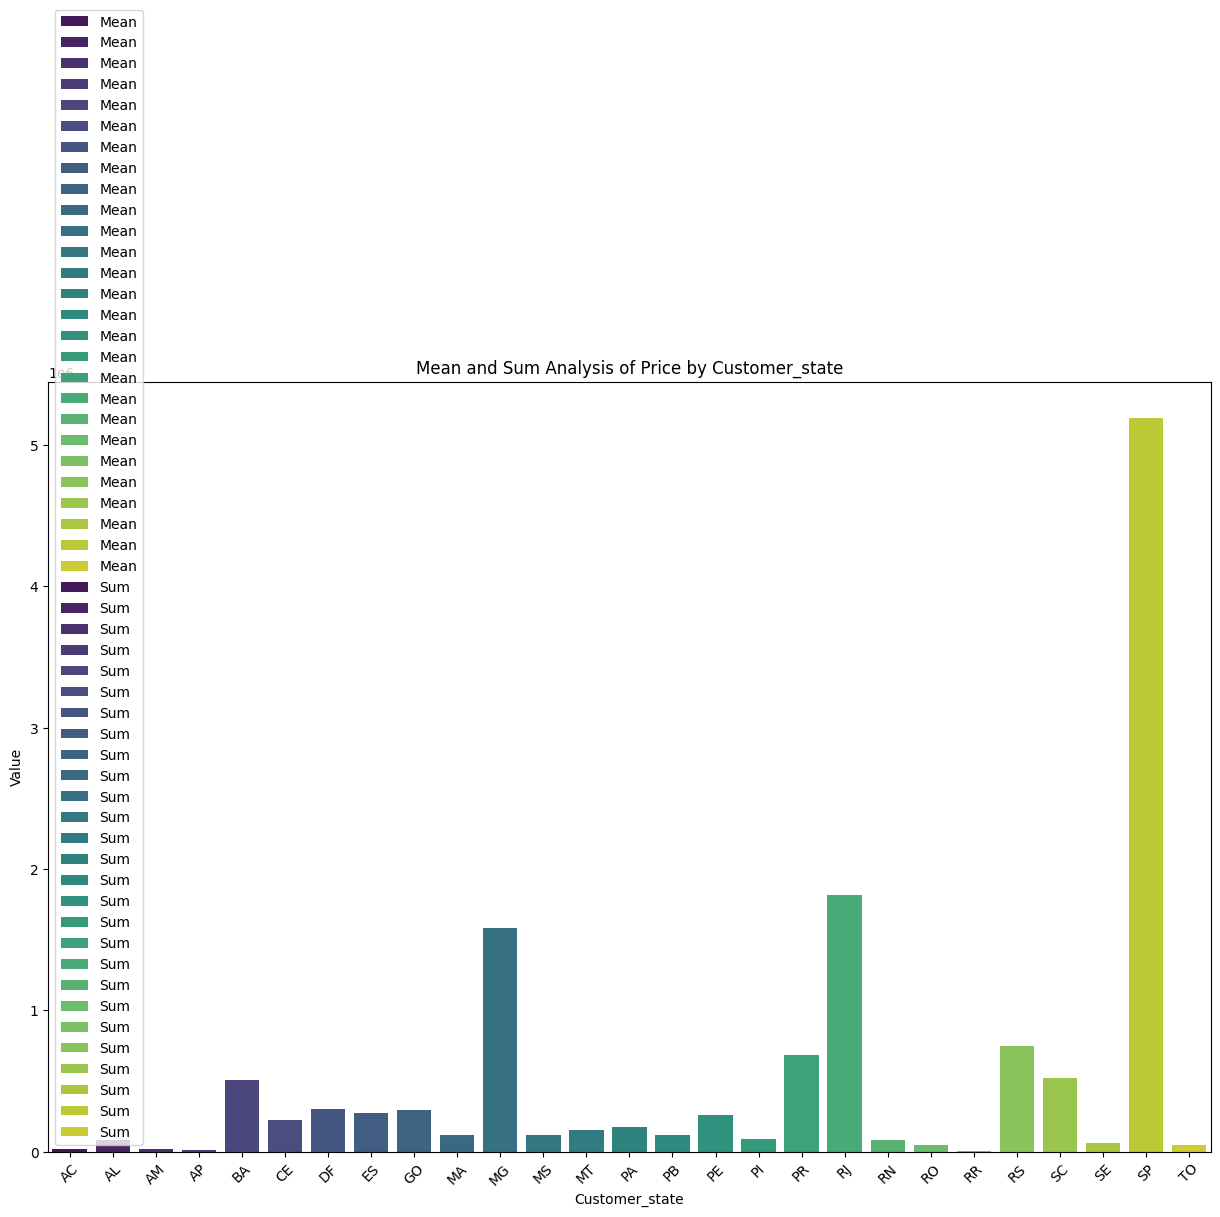

In [22]:
mean_sum_analysis(df_orders_filt, 'customer_state', 'price', palette='viridis', figsize=(15, 10))

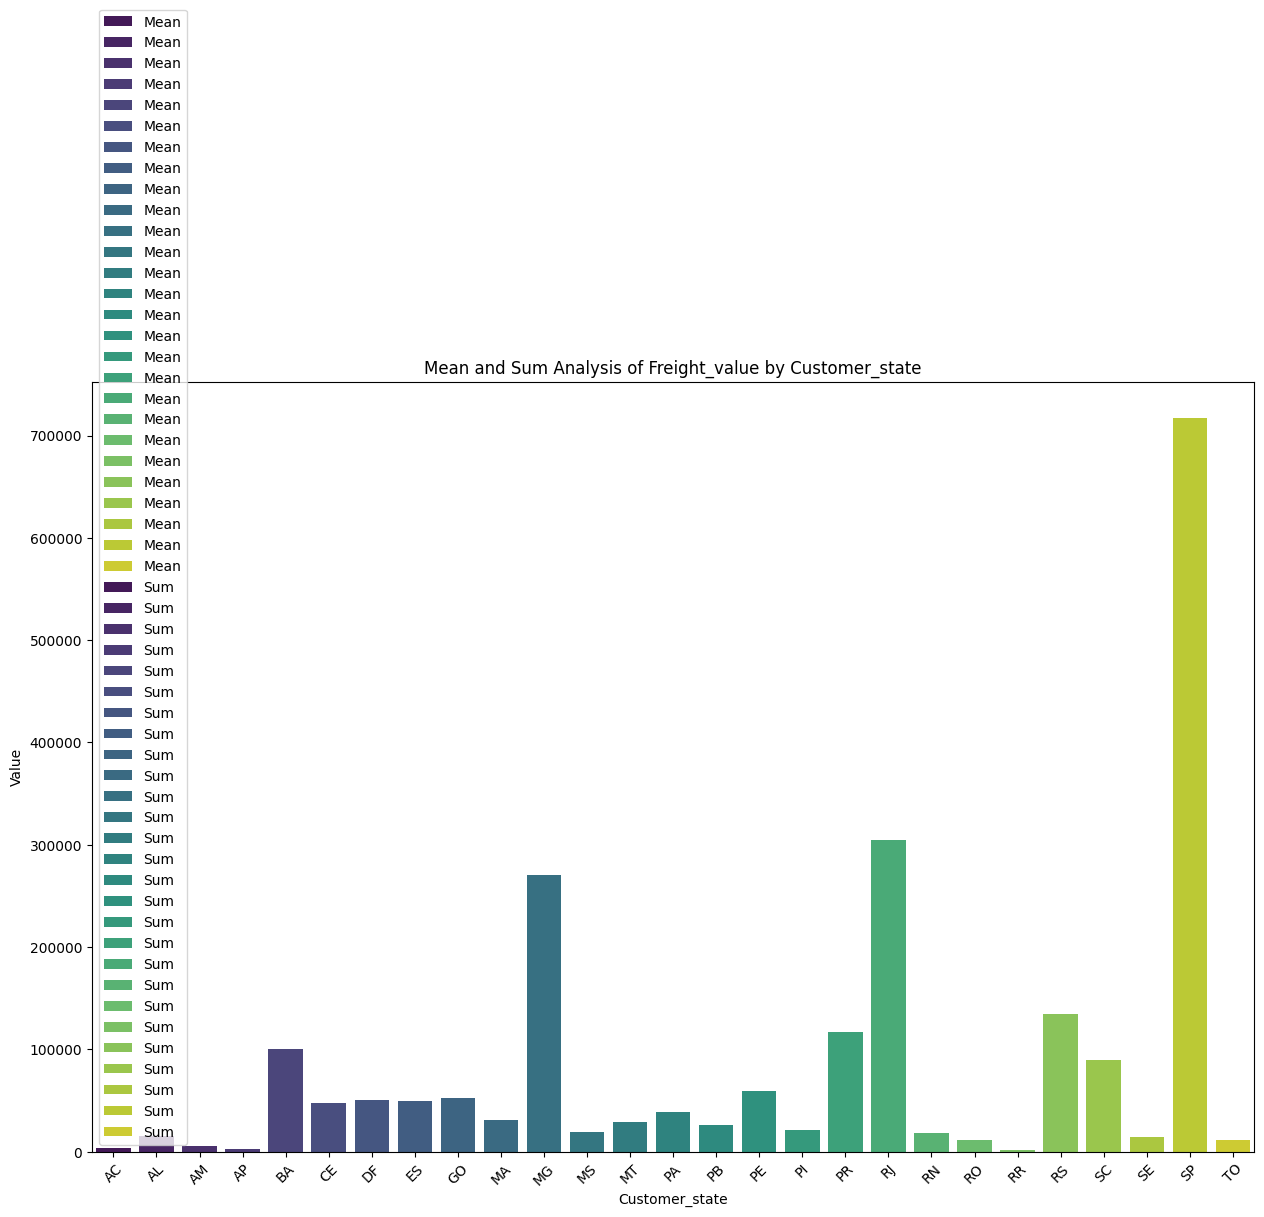

In [23]:
mean_sum_analysis(df_orders_filt, 'customer_state', 'freight_value', palette='viridis', figsize=(15, 10))

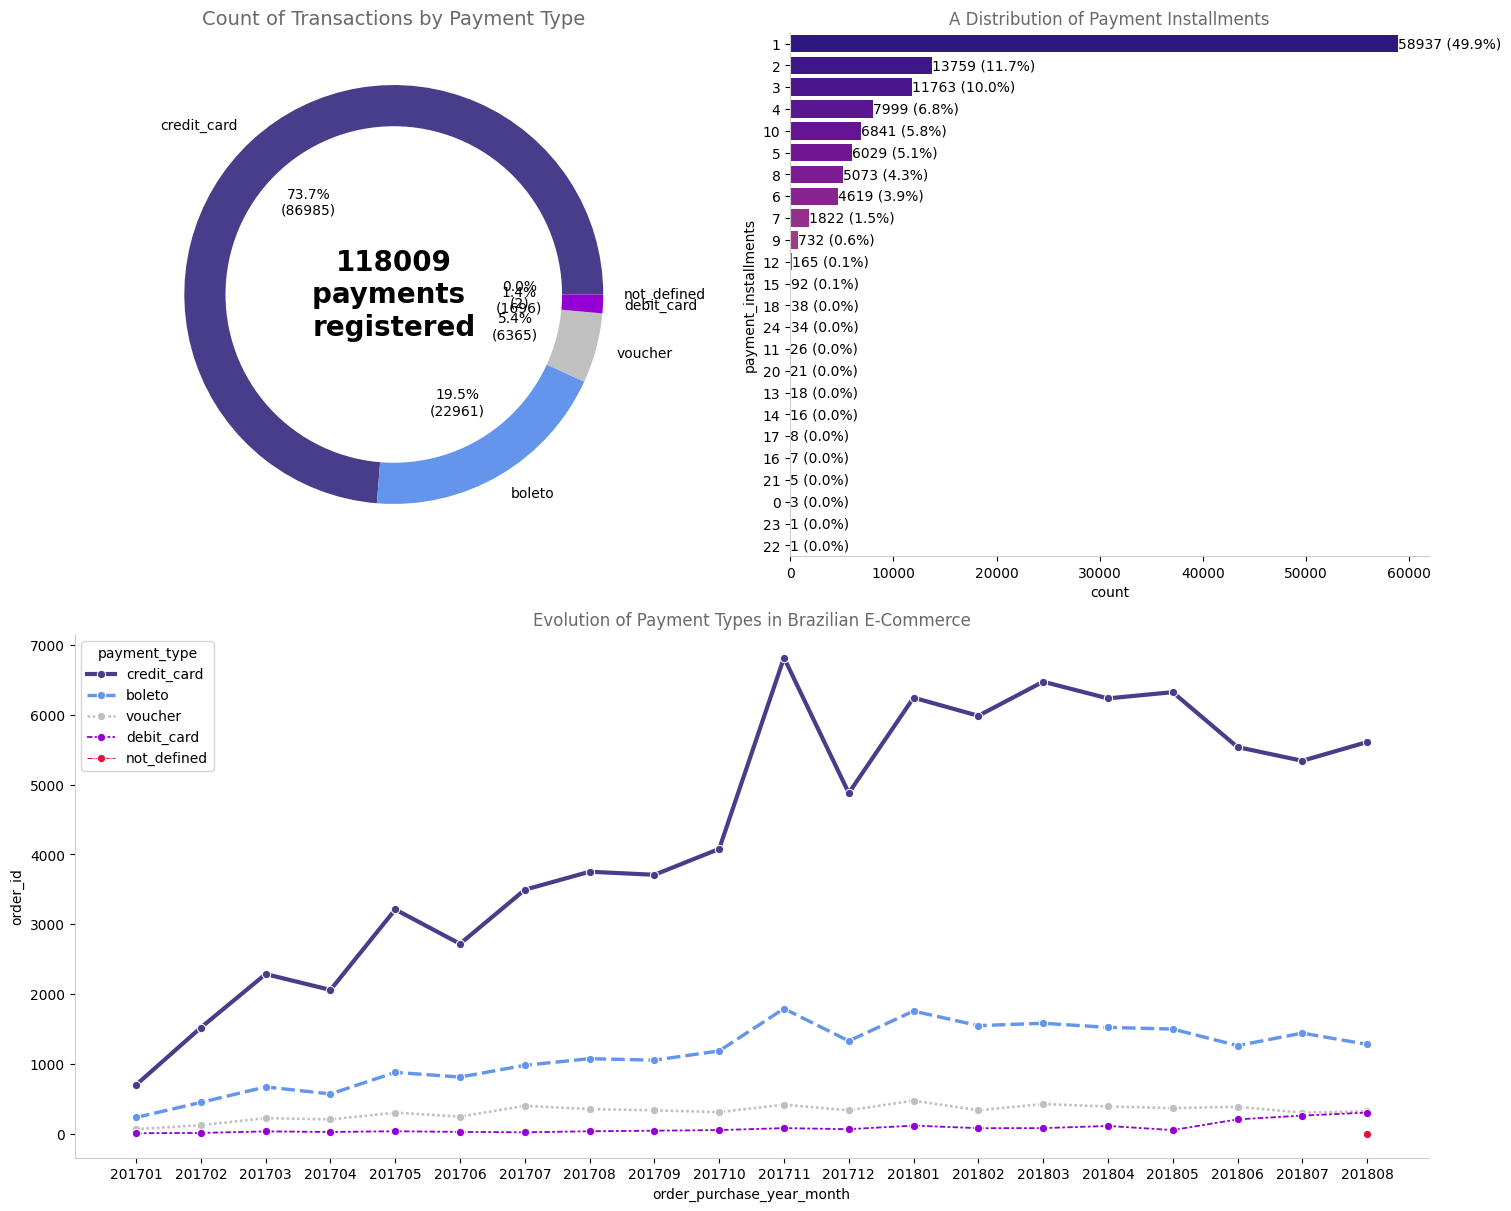

In [24]:
# Grouping data
df_orders_pay = df_orders_filt.merge(olist_order_payments, how='left', on='order_id')

# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# Plot 1 - Payment types in a donut chart
colors = ['darkslateblue', 'cornflowerblue', 'silver', 'darkviolet', 'crimson']
label_names = df_orders_pay['payment_type'].value_counts().index
donut_plot(df_orders_pay, col='payment_type', ax=ax1, label_names=label_names, colors=colors,
           title='Count of Transactions by Payment Type', text=f'{len(df_orders_pay)}\npayments \nregistered')

# Plot 2 - Payment installments
single_countplot(df_orders_pay, ax=ax2, y='payment_installments')
ax2.set_title('A Distribution of Payment Installments', color='dimgrey', size=12)

# Plot 3 - Evolution of payment types
payment_evl = df_orders_pay.groupby(by=['order_purchase_year_month', 'payment_type'], as_index=False).count()
payment_evl = payment_evl.loc[:, ['order_purchase_year_month', 'payment_type', 'order_id']]
payment_evl = payment_evl.sort_values(by=['order_purchase_year_month', 'order_id'], ascending=[True, False])
sns.lineplot(x='order_purchase_year_month', y='order_id', data=payment_evl, ax=ax3, hue='payment_type',
             style='payment_type', size='payment_type', palette=colors, marker='o')
format_spines(ax3, right_border=False)
ax3.set_title('Evolution of Payment Types in Brazilian E-Commerce', size=12, color='dimgrey')
plt.show()

## Data Distribution among classes

In [25]:
fig = px.bar(x = np.unique(data_cat["label"]),
             y = [list(data_cat["label"]).count(i) for i in np.unique(data_cat["label"])] , 
             color = np.unique(data_cat["label"]) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Ratings")
fig.update_yaxes(title = "Number of Reviews")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Rating vs No of reviews ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [26]:
fig = px.bar(x = np.unique(data_bin["label"]), 
             y = [list(data_bin["label"]).count(i) for i in np.unique(data_bin["label"])] , 
             color=np.unique(data_bin["label"]) ,
             color_continuous_scale="Emrld")  
fig.update_xaxes(title="Ratings")
fig.update_yaxes(title = "Number of Reviews")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Rating vs No of reviews ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

Due to data imbalanced in 5 different rating categories , we will work on binary classification problem instead. The output will be 0 and 1 representing NOT HAPPY and HAPPY respectively.

### WORDCLOUD

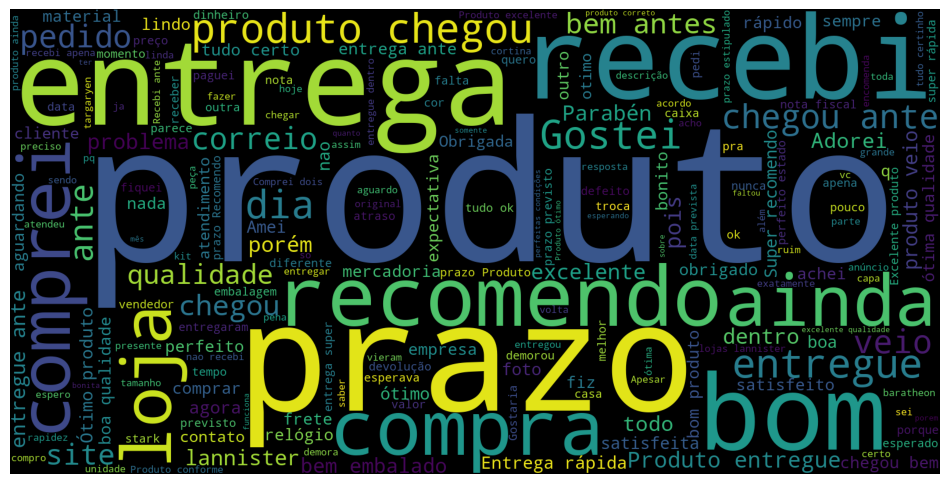

In [27]:
stop_words = stopwords.words('portuguese')
wordcloud = WordCloud(stopwords=stop_words,
                      background_color="black",
                      width=1600, height=800).generate(' '.join(data_bin["text"]))
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

In [28]:
def split_test_train(data, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE):
    df_train = data.sample(frac = split_train, random_state = random_state)
    df_test = data.drop(df_train.index)

    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for index, train in df_train.iterrows():
        X_train.append(str(train['text']))
        y_train.append(train['label'])
    
    for index, test in df_test.iterrows():
        X_test.append(str(test['text']))
        y_test.append(test['label'])
        
    y_train = np.array(y_train)
    y_test = np.array(y_test) 
    
    return X_train , y_train , X_test , y_test


X_train , y_train , X_test , y_test = split_test_train(data_bin, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE)

In [29]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(X_train)

def preprocess(X_train, X_test, max_length, vocab_size, trunc_type='post', oov_tok = "<OOV>"):

    training_sequences = tokenizer.texts_to_sequences(X_train)
    X_train_padded = pad_sequences(training_sequences,maxlen=max_length, truncating=trunc_type)
    
    testing_sequences = tokenizer.texts_to_sequences(X_test)
    X_test_padded = pad_sequences(testing_sequences,maxlen=max_length)
    
    return X_train_padded, X_test_padded

X_train, X_test = preprocess(X_train, X_test, MAX_LENGTH, VOCAB_SIZE)

<a id="lstm"></a>
# <center> NN-LSTM MODEL </center>

In [30]:
def create_model():
    
    input = tf.keras.Input(shape=(MAX_LENGTH))
    
    x = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH)(input)
    x = tf.keras.layers.LSTM(32, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(32)(x)
    x = tf.keras.layers.Dropout(DROPOUT_P)(x)
    
    x = tf.keras.layers.Dense(800, activation='relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_P)(x)
    x = tf.keras.layers.Dense(400, activation='relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_P)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(input, output)

    return model

In [31]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

model = create_model()

model.compile(
  loss = tf.keras.losses.BinaryCrossentropy(),
  optimizer= tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE , momentum=MOMENTUM),
  metrics=['accuracy']
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120)]             0         
                                                                 
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 lstm (LSTM)                 (None, 120, 32)           6272      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 800)               26400     
                                                                 
 dropout_1 (Dropout)         (None, 800)               0    

## Training LSTM Model

In [32]:
history = model.fit(x = X_train,
                    y = y_train, 
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks= [earlyStoppingCallback]
)
history = pd.DataFrame(history.history)

Epoch 1/25


257/257 [==============================] - 42s 146ms/step - loss: 0.5805 - accuracy: 0.7348 - val_loss: 0.5547 - val_accuracy: 0.7307
Epoch 2/25
257/257 [==============================] - 35s 138ms/step - loss: 0.5212 - accuracy: 0.7462 - val_loss: 0.5027 - val_accuracy: 0.7596
Epoch 3/25
257/257 [==============================] - 39s 151ms/step - loss: 0.4707 - accuracy: 0.7766 - val_loss: 0.3941 - val_accuracy: 0.8199
Epoch 4/25
257/257 [==============================] - 38s 149ms/step - loss: 0.3703 - accuracy: 0.8293 - val_loss: 0.3496 - val_accuracy: 0.8454
Epoch 5/25
257/257 [==============================] - 35s 134ms/step - loss: 0.3327 - accuracy: 0.8524 - val_loss: 0.3112 - val_accuracy: 0.8594
Epoch 6/25
257/257 [==============================] - 38s 147ms/step - loss: 0.3094 - accuracy: 0.8643 - val_loss: 0.3225 - val_accuracy: 0.8641
Epoch 7/25
257/257 [==============================] - 36s 139ms/step - loss: 0.2941 - accuracy: 0.8722 - val_loss: 0.2842 - val_

## Visualizing Training Results

In [33]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] , 
            markers = True )
x.update_xaxes(title="Number of Epochs",
              rangeslider_visible = True)
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [34]:
x = px.line(data_frame= history , 
            y= ["loss" , "val_loss"] , 
            markers = True )
x.update_xaxes(title="Number of Epochs",
              rangeslider_visible = True)
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

## Evaluating LSTM model

In [35]:
y_preds_prob = model.predict(X_test, verbose=0)
y_preds = np.where(y_preds_prob> 0.5, 1, 0)
y_preds_prob = y_preds_prob[:, 0]
y_preds = y_preds[:, 0]

[loss,accuracy] = model.evaluate(X_test, y_test ,verbose = 0 )
print("Accuracy on Test Data :", accuracy*100 ,"%")
print(classification_report(y_test ,y_preds))

Accuracy on Test Data : 89.48138952255249 %
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      2207
           1       0.96      0.90      0.93      5988

    accuracy                           0.89      8195
   macro avg       0.86      0.89      0.87      8195
weighted avg       0.90      0.89      0.90      8195



In [48]:
[loss,accuracy1] = model.evaluate(X_train, y_train ,verbose = 0 )
print("Accuracy on train Data :", accuracy1*100 ,"%")

Accuracy on train Data : 91.08962416648865 %


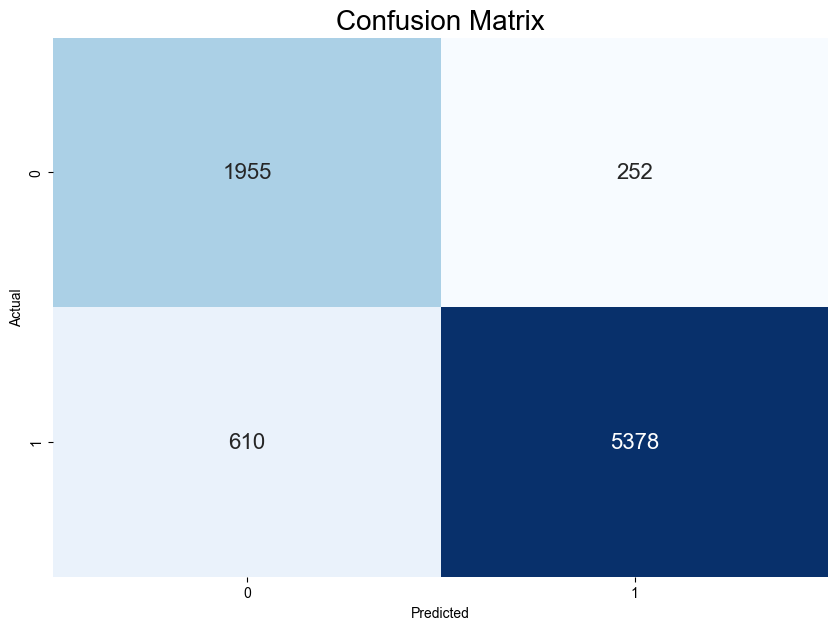

In [36]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=[0,1], index = [0,1])
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix', fontsize = 20)

sns.set(font_scale=1.4)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

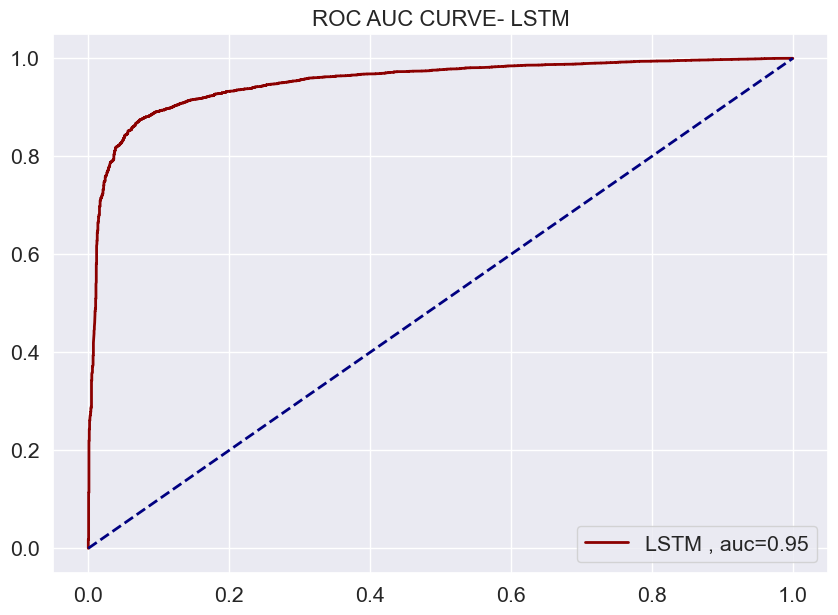

In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds  = roc_curve(y_test, y_preds_prob)
auc = roc_auc_score(y_test, y_preds_prob)
plt.figure(figsize = (10,7))
plt.plot(fpr,tpr,color='darkred', lw=2, label="LSTM , auc="+str(round(auc,2)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC AUC CURVE- LSTM', fontsize = 16)
plt.legend(loc=4)
plt.show()

<a id="com"></a>
# <center> COMPARISON WITH OTHER MODELS </center> 

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

<a id="lr"></a>
# LOGISTIC REGRESSION

In [39]:
lr = LogisticRegression(max_iter= MAX_ITER,random_state=RANDOM_STATE, n_jobs= N_JOBS)
lr.fit(X_train,y_train)
lr_preds = lr.predict(X_test)
print("Model score on Training Data = ", lr.score(X_train,y_train)*100,"%")
print("Model score on Testing Data = ", lr.score(X_test,y_test)*100,"%")

Model score on Training Data =  74.49820023183455 %
Model score on Testing Data =  73.30079316656499 %


In [50]:
report = classification_report(y_test, lr_preds)
print(report)


              precision    recall  f1-score   support

           0       0.53      0.08      0.15      2207
           1       0.74      0.97      0.84      5988

    accuracy                           0.73      8195
   macro avg       0.63      0.53      0.49      8195
weighted avg       0.68      0.73      0.65      8195



<a id="nb"></a>
# NAIVE BAYES

In [40]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
nb_preds = nb.predict(X_test)
print("Model score on Training Data = ", nb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", nb.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  74.55615886767129 %
Model score on Testing Data =  74.35021354484441 %


In [51]:
print(classification_report(y_test ,nb_preds))

              precision    recall  f1-score   support

           0       0.53      0.37      0.44      2207
           1       0.79      0.88      0.83      5988

    accuracy                           0.74      8195
   macro avg       0.66      0.63      0.64      8195
weighted avg       0.72      0.74      0.73      8195



<a id="sv"></a>
# SUPPORT VECTOR CLASSIFIER (SVC)

In [41]:
svm = SVC(random_state=RANDOM_STATE , verbose = True)
svm.fit(X_train,y_train)
sv_preds = svm.predict(X_test)
print("Model score on Training Data = ", svm.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", svm.score(X_test,y_test)*100 ,"%")

[LibSVM]Model score on Training Data =  79.7907388200842 %
Model score on Testing Data =  74.49664429530202 %


In [52]:
print(classification_report(y_test ,sv_preds))

              precision    recall  f1-score   support

           0       0.57      0.21      0.30      2207
           1       0.76      0.94      0.84      5988

    accuracy                           0.74      8195
   macro avg       0.67      0.57      0.57      8195
weighted avg       0.71      0.74      0.70      8195



<a id="rf"></a>
#  RANDOM FOREST CLASSIFIER

In [42]:
rfc = RandomForestClassifier(n_estimators = 100, random_state =RANDOM_STATE , n_jobs = N_JOBS)
rfc.fit(X_train,y_train)
rf_preds = rfc.predict(X_test)
print("Model score on Training Data = ", rfc.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", rfc.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  99.5790372765542 %
Model score on Testing Data =  78.40146430750458 %


In [53]:
print(classification_report(y_test ,rf_preds))

              precision    recall  f1-score   support

           0       0.65      0.43      0.52      2207
           1       0.81      0.91      0.86      5988

    accuracy                           0.78      8195
   macro avg       0.73      0.67      0.69      8195
weighted avg       0.77      0.78      0.77      8195



<a id="xg"></a>
# XGBOOST CLASSIFIER

In [43]:
xgb = XGBClassifier(objective='binary:logistic' , 
                    use_label_encoder=False,  
                    random_state = RANDOM_STATE,
                    eval_metric='mlogloss')
xgb.fit(X_train,y_train)
xg_preds = xgb.predict(X_test)
print("Model score on Training Data = ", xgb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", xgb.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  93.8167286925752 %
Model score on Testing Data =  82.91641244661379 %


In [54]:
print(classification_report(y_test ,xg_preds))

              precision    recall  f1-score   support

           0       0.72      0.60      0.66      2207
           1       0.86      0.91      0.89      5988

    accuracy                           0.83      8195
   macro avg       0.79      0.76      0.77      8195
weighted avg       0.82      0.83      0.82      8195



<a id="per"></a>
# <center> PERFORMANCE METRICS COMPARISON </center> 

## Test Accuracies Comparison

In [44]:
results = pd.DataFrame(data  = [accuracy*100] , columns =["NN-Lstm"] , index = ["Test Accuracy"])
results['Logistic Regression'] = lr.score(X_test,y_test)*100
results['Naive Bayes'] = nb.score(X_test,y_test)*100
results['Support Vector Machine (SVM)'] = svm.score(X_test,y_test)*100
results['RandomForest Classifier'] = rfc.score(X_test,y_test)*100
results['XGBoost Classifier'] = xgb.score(X_test,y_test)*100
results = results.transpose()
x = px.line(data_frame= results, y = ["Test Accuracy"] ,markers = True  )
x.update_xaxes(title="Model Name")
x.update_yaxes(title = "Test Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Test Accuracy comparison of all 6 models',
        'y':0.94,'x':0.5,'xanchor': 'center','yanchor': 'top'})
x.show()

In [56]:
results = pd.DataFrame(data  = [accuracy1*100] , columns =["NN-Lstm"] , index = ["Train Accuracy"])
results['Logistic Regression'] = lr.score(X_train,y_train)*100
results['Naive Bayes'] = nb.score(X_train,y_train)*100
results['Support Vector Machine (SVM)'] = svm.score(X_train,y_train)*100
results['RandomForest Classifier'] = rfc.score(X_train,y_train)*100
results['XGBoost Classifier'] = xgb.score(X_train,y_train)*100
results = results.transpose()
x = px.line(data_frame= results, y = ["Train Accuracy"] ,markers = True  )
x.update_xaxes(title="Model Name")
x.update_yaxes(title = "Train Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Train Accuracy comparison of all 6 models',
        'y':0.94,'x':0.5,'xanchor': 'center','yanchor': 'top'})

## Confusion Matrix Comparison

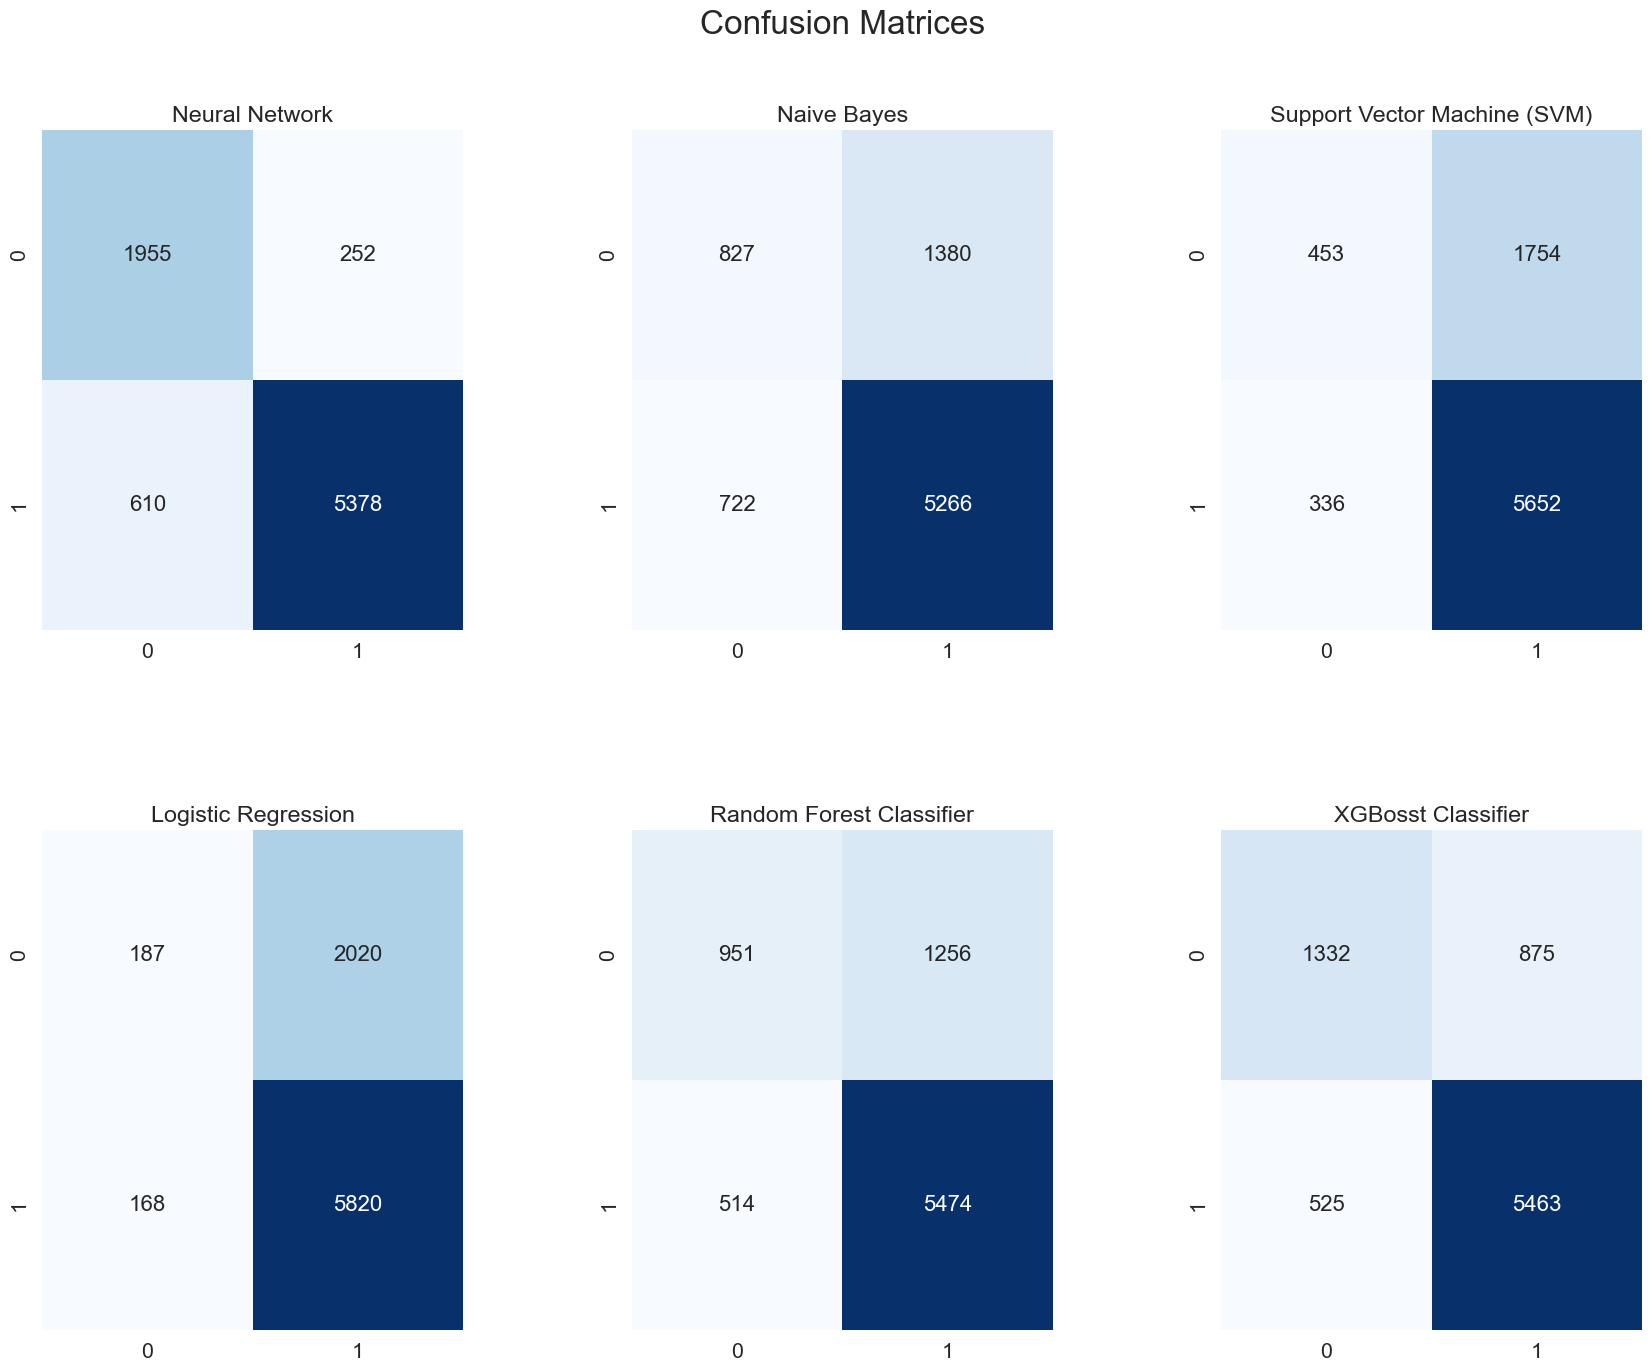

In [45]:
lr_cm=confusion_matrix(y_test, lr_preds )
nb_cm=confusion_matrix(y_test, nb_preds)
svm_cm=confusion_matrix(y_test, sv_preds)
nn_cm= confusion_matrix(y_test,y_preds)
rf_cm = confusion_matrix(y_test,rf_preds)
xg_cm = confusion_matrix(y_test,xg_preds)

plt.figure(figsize=(20,15))
plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(2,3,1)
plt.title("Neural Network")
sns.heatmap(nn_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');


plt.subplot(2,3,2)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,3)
plt.title("Support Vector Machine (SVM)")
sns.heatmap(svm_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,4)
plt.title("Logistic Regression")
sns.heatmap(lr_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,5)
plt.title("Random Forest Classifier")
sns.heatmap(rf_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,6)
plt.title("XGBosst Classifier")
sns.heatmap(xg_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

## ROC-AUC Curves Comparison

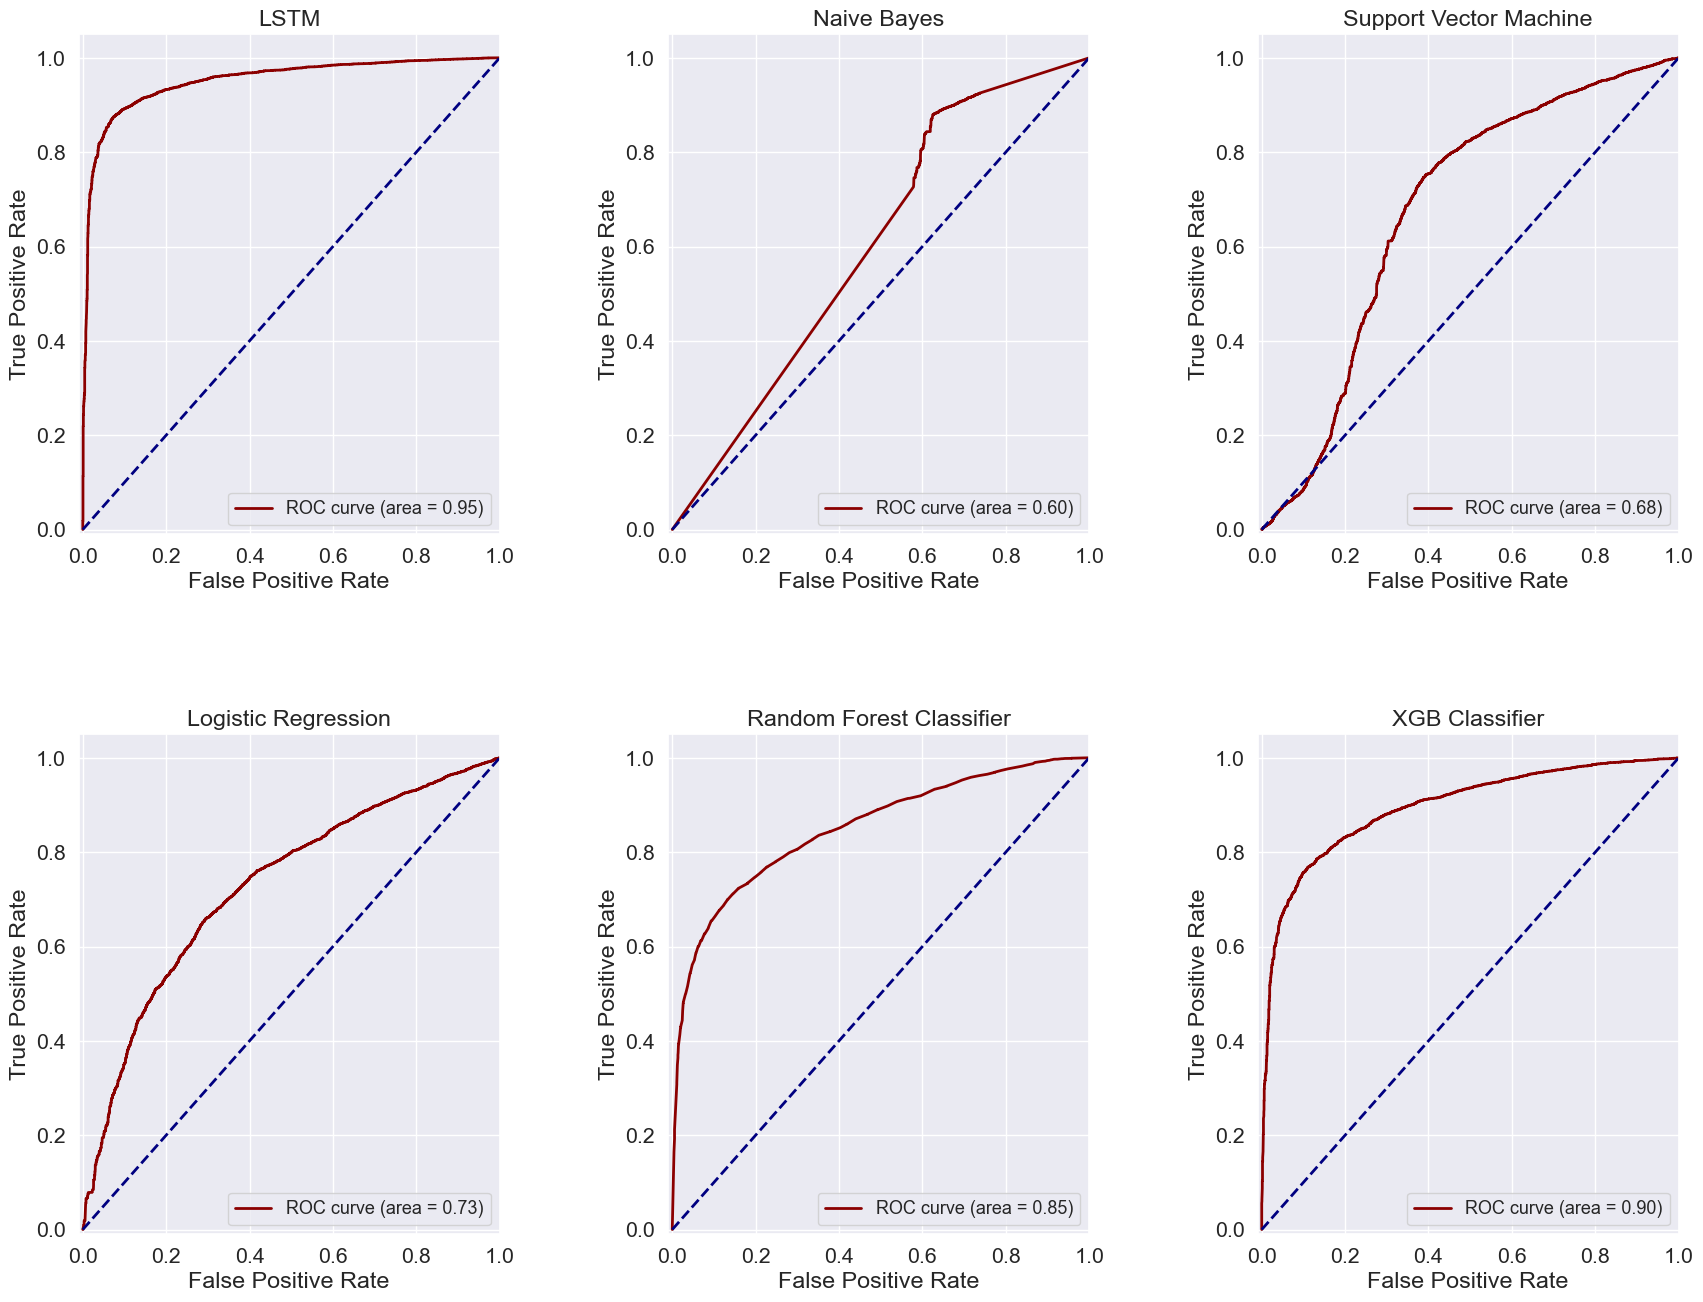

In [46]:
from sklearn.metrics import auc
pred_lr = lr.predict_proba(X_test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

pred_nb = nb.predict_proba(X_test)[:,1]
fpr_nb,tpr_nb,_ = roc_curve(y_test,pred_nb)
roc_auc_nb = auc(fpr_nb,tpr_nb)

pred_svm = svm.decision_function(X_test)
fpr_svm,tpr_svm,_ = roc_curve(y_test,pred_svm)
roc_auc_svm = auc(fpr_svm,tpr_svm)

fpr_nn, tpr_nn, _  = roc_curve(y_test, y_preds_prob)
roc_auc_nn = auc(fpr_nn,tpr_nn)

pred_rf = rfc.predict_proba(X_test)[:,1]
fpr_rf,tpr_rf,_ = roc_curve(y_test,pred_rf)
roc_auc_rf = auc(fpr_rf,tpr_rf)

pred_xg = xgb.predict_proba(X_test)[:,1]
fpr_xg,tpr_xg,_ = roc_curve(y_test,pred_xg)
roc_auc_xg = auc(fpr_xg,tpr_xg)

f, axes = plt.subplots(2,3,figsize=(20,15))
axes[0,0].plot(fpr_nn, tpr_nn, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nn))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'LSTM')
axes[0,0].legend(loc='lower right', fontsize=13);


axes[0,1].plot(fpr_nb, tpr_nb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Naive Bayes')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[0,2].plot(fpr_svm, tpr_svm, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_svm))
axes[0,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Support Vector Machine')
axes[0,2].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Logistic Regression')
axes[1,0].legend(loc='lower right', fontsize=13)


axes[1,1].plot(fpr_rf, tpr_rf, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_rf))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Random Forest Classifier')
axes[1,1].legend(loc='lower right', fontsize=13);


axes[1,2].plot(fpr_xg, tpr_xg, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_xg))
axes[1,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'XGB Classifier')
axes[1,2].legend(loc='lower right', fontsize=13);


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
